In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from scipy.stats import chi2_contingency, ks_2samp, loguniform
from sklearn.metrics import matthews_corrcoef
import warnings
warnings.filterwarnings("ignore")
import random
import matplotlib.ticker as tkr
from imblearn.over_sampling import SMOTENC
#from optbinning import BinningProcess

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from itertools import compress

<H1> Intro <H1>

The goal of this project is to pre-process the provided data file and then create a model whose task will be to
predict outcomes for a given business case.

Our project will be implemented in accordance with the CRISP-DM (Cross Industry Standard Process for Data Mining) methodology, which is a process model that serves as the basis for data science processes and consists of six steps: Business understanding, data understanding, data preparation, modeling, model evaluation and deployment.

Within the framework of this project, we will use one tool for individual tasks - the Python programming language, both for data preparation and subsequent modeling. Python is an open source, object-oriented, high-level programming language. It is widely used due to its easy-to-understand and learnable syntax (resulting in reduced program maintenance costs). Furthermore, it supports an infinite number of modules and packages (Python Software Foundation, 2019). This is especially true for data science libraries. The most common are: NumPy, Pandas, Matplotlib, SciPy or Scikit-learn (GeeksforGeeks, 2022), which we will also use in our project.

In [263]:
# load data from git
dataset = pd.read_csv('https://raw.githubusercontent.com/Doll03/4IZ480/main/Data/TimeDeposit_10K.csv', sep=";")


<H1> Business case <H1>

Before data exploratory analysis, it is necessary to understand and define the goal of our business case. This step is necessary and mandatory for any data mining project. It usually involves identifying and describing the basic project objectives from a business perspective and then establishing a set of project objectives and requirements that are used to develop the project plan.

As this data is about a banking institution and its customers, we therefore want to create a model that will predict whether a customer will open a new term deposit.
With the help of the given model, the banking institution can not only reduce its costs to avoid targeting the wrong customers, but also increase its profits by targeting the relevant ones. In other words, we would like to classify clients according to the probability of opening a new term deposit, and based on this, the banking institution can adjust its business strategy and customer relations.

<H1>Data understanding<H1>

This step can consist of three sub-steps – data collection, data description and exploratory data analysis. With regard to data collection, this dataset was provided to us by the course professor in csv format along with a description of the dataset. The data file provided contains 46 columns and 10,000 rows, where each row represents one customer of a given bank with the information listed in the columns. In particular, this data set contains customer demographic information (such as gender, marital status, age), financial information (income, balances) and transaction information (number of transactions, transaction amounts). Lastly the last column of the dataset states whether the customer opened a new term deposit or not.

In [264]:
#change of features datatypes 
dataset["Customer_ID"] = dataset["Customer_ID"].astype("object")
dataset["Birth_Date"] = dataset["Birth_Date"].astype("datetime64")
dataset["Ref_Date"] = dataset["Ref_Date"].astype("datetime64")
dataset["Gender"] = dataset["Gender"].astype("category")
dataset["Marital_Status"] = dataset["Marital_Status"].astype("category")
dataset["Children_Num"] = dataset["Children_Num"].astype("category")
dataset["Occupation_Category"] = dataset["Occupation_Category"].astype("category")
dataset["Payroll_Flag"] = dataset["Payroll_Flag"].astype("bool")
dataset["Business_Flag"] = dataset["Business_Flag"].astype("bool")
dataset["Saving_Current_Accounts_Flag"] = dataset["Saving_Current_Accounts_Flag"].astype("bool")
dataset["Investment_Products_Flag"] = dataset["Investment_Products_Flag"].astype("bool")
dataset["Insurance_Products_Flag"] = dataset["Insurance_Products_Flag"].astype("bool")
dataset["Business_Loans_Flag"] = dataset["Business_Loans_Flag"].astype("bool")
dataset["Housing_Loans_Flag"] = dataset["Housing_Loans_Flag"].astype("bool")
dataset["Consumer_Loans_Flag"] = dataset["Consumer_Loans_Flag"].astype("bool")
dataset["Credit_Cards_Flag"] = dataset["Credit_Cards_Flag"].astype("bool")
dataset["Time_Deposits_Flag"] = [True if i == "T" else False for i in dataset['Time_Deposits_Flag']]



In [265]:
#Creating boolean features 
dataset["Credit_Cards_Installments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Installments']]
dataset["Credit_Cards_Payments_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Payments_Num']]
dataset["Credit_Cards_Purchases_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Purchases_Num']]
dataset["Credit_Cards_Witrhdrawals_Flag"] = [True if i > 0 else False for i in dataset['Credit_Cards_Witrhdrawals_Num']]
dataset["Internet_Trans_Flag"] = [True if i > 0 else False for i in dataset['Internet_Trans_Num']]
dataset["Deposit_Trans_Flag"] = [True if i > 0 else False for i in dataset['Deposit_Trans_Num']]
dataset["Payment_Trans_Flag"] = [True if i > 0 else False for i in dataset['Payment_Trans_Num']]
dataset["Transfer_Trans_Flag"] = [True if i > 0 else False for i in dataset['Transfer_Trans_Num']]
dataset["Withdrawl_Trans_Flag"] = [True if i > 0 else False for i in dataset['Withdrawl_Trans_Num']]

Before starting the exploratory analysis of features, we decided to change one of them to different datatype. Feature age was changed into categorical variable with 4 bins, which were found thanks to optimal binning process.

In [266]:
#Creating feature Age_Cat
dataset['Age'] = dataset['Ref_Date'].dt.year - dataset['Birth_Date'].dt.year
dataset['Age_Cat'] = pd.cut(dataset['Age'], bins=[0, 32.50, 51.50, 60.50, 150],labels=['Younger', 'LowerMid', 'UpperMid', 'Older'])


<H1>Target and feature distribution<H1>

False    0.9897
True     0.0103
Name: Time_Deposits_Flag, dtype: float64


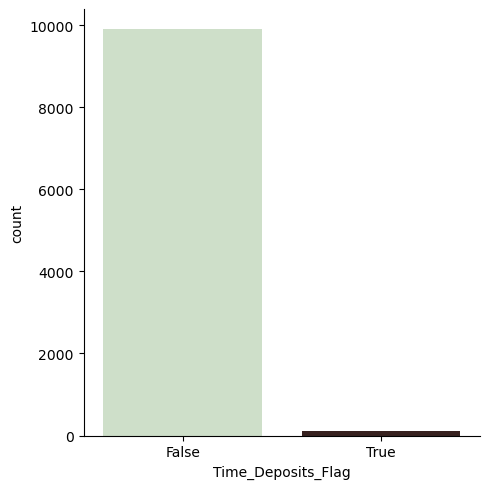

In [267]:
# show histogram of target variable
print(dataset["Time_Deposits_Flag"].value_counts(normalize=True))
sns.catplot(data = dataset, x = "Time_Deposits_Flag", kind = "count", palette = "ch:.79")
plt.show()

In the graph above, we can see the distribution of the target variable Time_Deposits_Flag, according to which the target variable is heavily imbalanced. If this issue will not be treated, the model would focus primarily on the majority class instead and might bias the predictions.
This issue can be dealt with oversampling and/or undersampling. With regards to the undersampling technique, this will not be used since we would lose significant amount of information by removing the instances with the majority class. Therefore we will use oversampling method later.

In [268]:
#change of target datatype
dataset['Time_Deposits_Flag']=dataset['Time_Deposits_Flag'].astype('category')

In [269]:
# dropping unnecessary variables as Ref_Date and Birth_Date were used to form a new feature, Customer_ID is just 
# unique number of each customer and lastly Age has been replaced by Age_Cat
dataset = dataset.drop(["Ref_Date","Birth_Date","Customer_ID","Age" ], axis = "columns", errors="ignore")

In [270]:
#crealing list of categorical features
cat_v_list = [i for i in list(dataset.columns) if (dataset[i].dtypes in ['O', 'bool', "category"])]
cat_v_list.remove('Time_Deposits_Flag')

#creating list of numerical features
num_v_list = [i for i in list(dataset.columns) if i not in cat_v_list]
num_v_list.remove('Time_Deposits_Flag')
print("Num:", num_v_list, "end=", "Cat:", cat_v_list)


Num: ['Total_Income', 'Saving_Current_Balance', 'Investment_Products_Balance', 'Insurance_Balances', 'Business_Loans_Balance', 'Housing_Loans_Balance', 'Consumer_Loans_Balance', 'Credit_Cards_Balance', 'Branch_Trans_Num', 'ATM_Trans_Num', 'APS_Trans_Num', 'Phone_Trans_Num', 'Internet_Trans_Num', 'Deposit_Trans_Num', 'Withdrawl_Trans_Num', 'Payment_Trans_Num', 'Transfer_Trans_Num', 'Deposit_Trans_Amount', 'Withdrawl_Trans_Amount', 'Payment_Trans_Amount', 'Transfer_Trans_Amount', 'Credit_Cards_Installments', 'Credit_Cards_Payments_Num', 'Credit_Cards_Purchases_Num', 'Credit_Cards_Witrhdrawals_Num', 'Credit_Cards_Payments_Amount', 'Credit_Cards_Purchases_Amount', 'Credit_Cards_Witrhdrawals_Amount', 'Arrears_Months_Max'] end= Cat: ['Gender', 'Marital_Status', 'Children_Num', 'Occupation_Category', 'Payroll_Flag', 'Business_Flag', 'Saving_Current_Accounts_Flag', 'Investment_Products_Flag', 'Insurance_Products_Flag', 'Business_Loans_Flag', 'Housing_Loans_Flag', 'Consumer_Loans_Flag', 'Credit

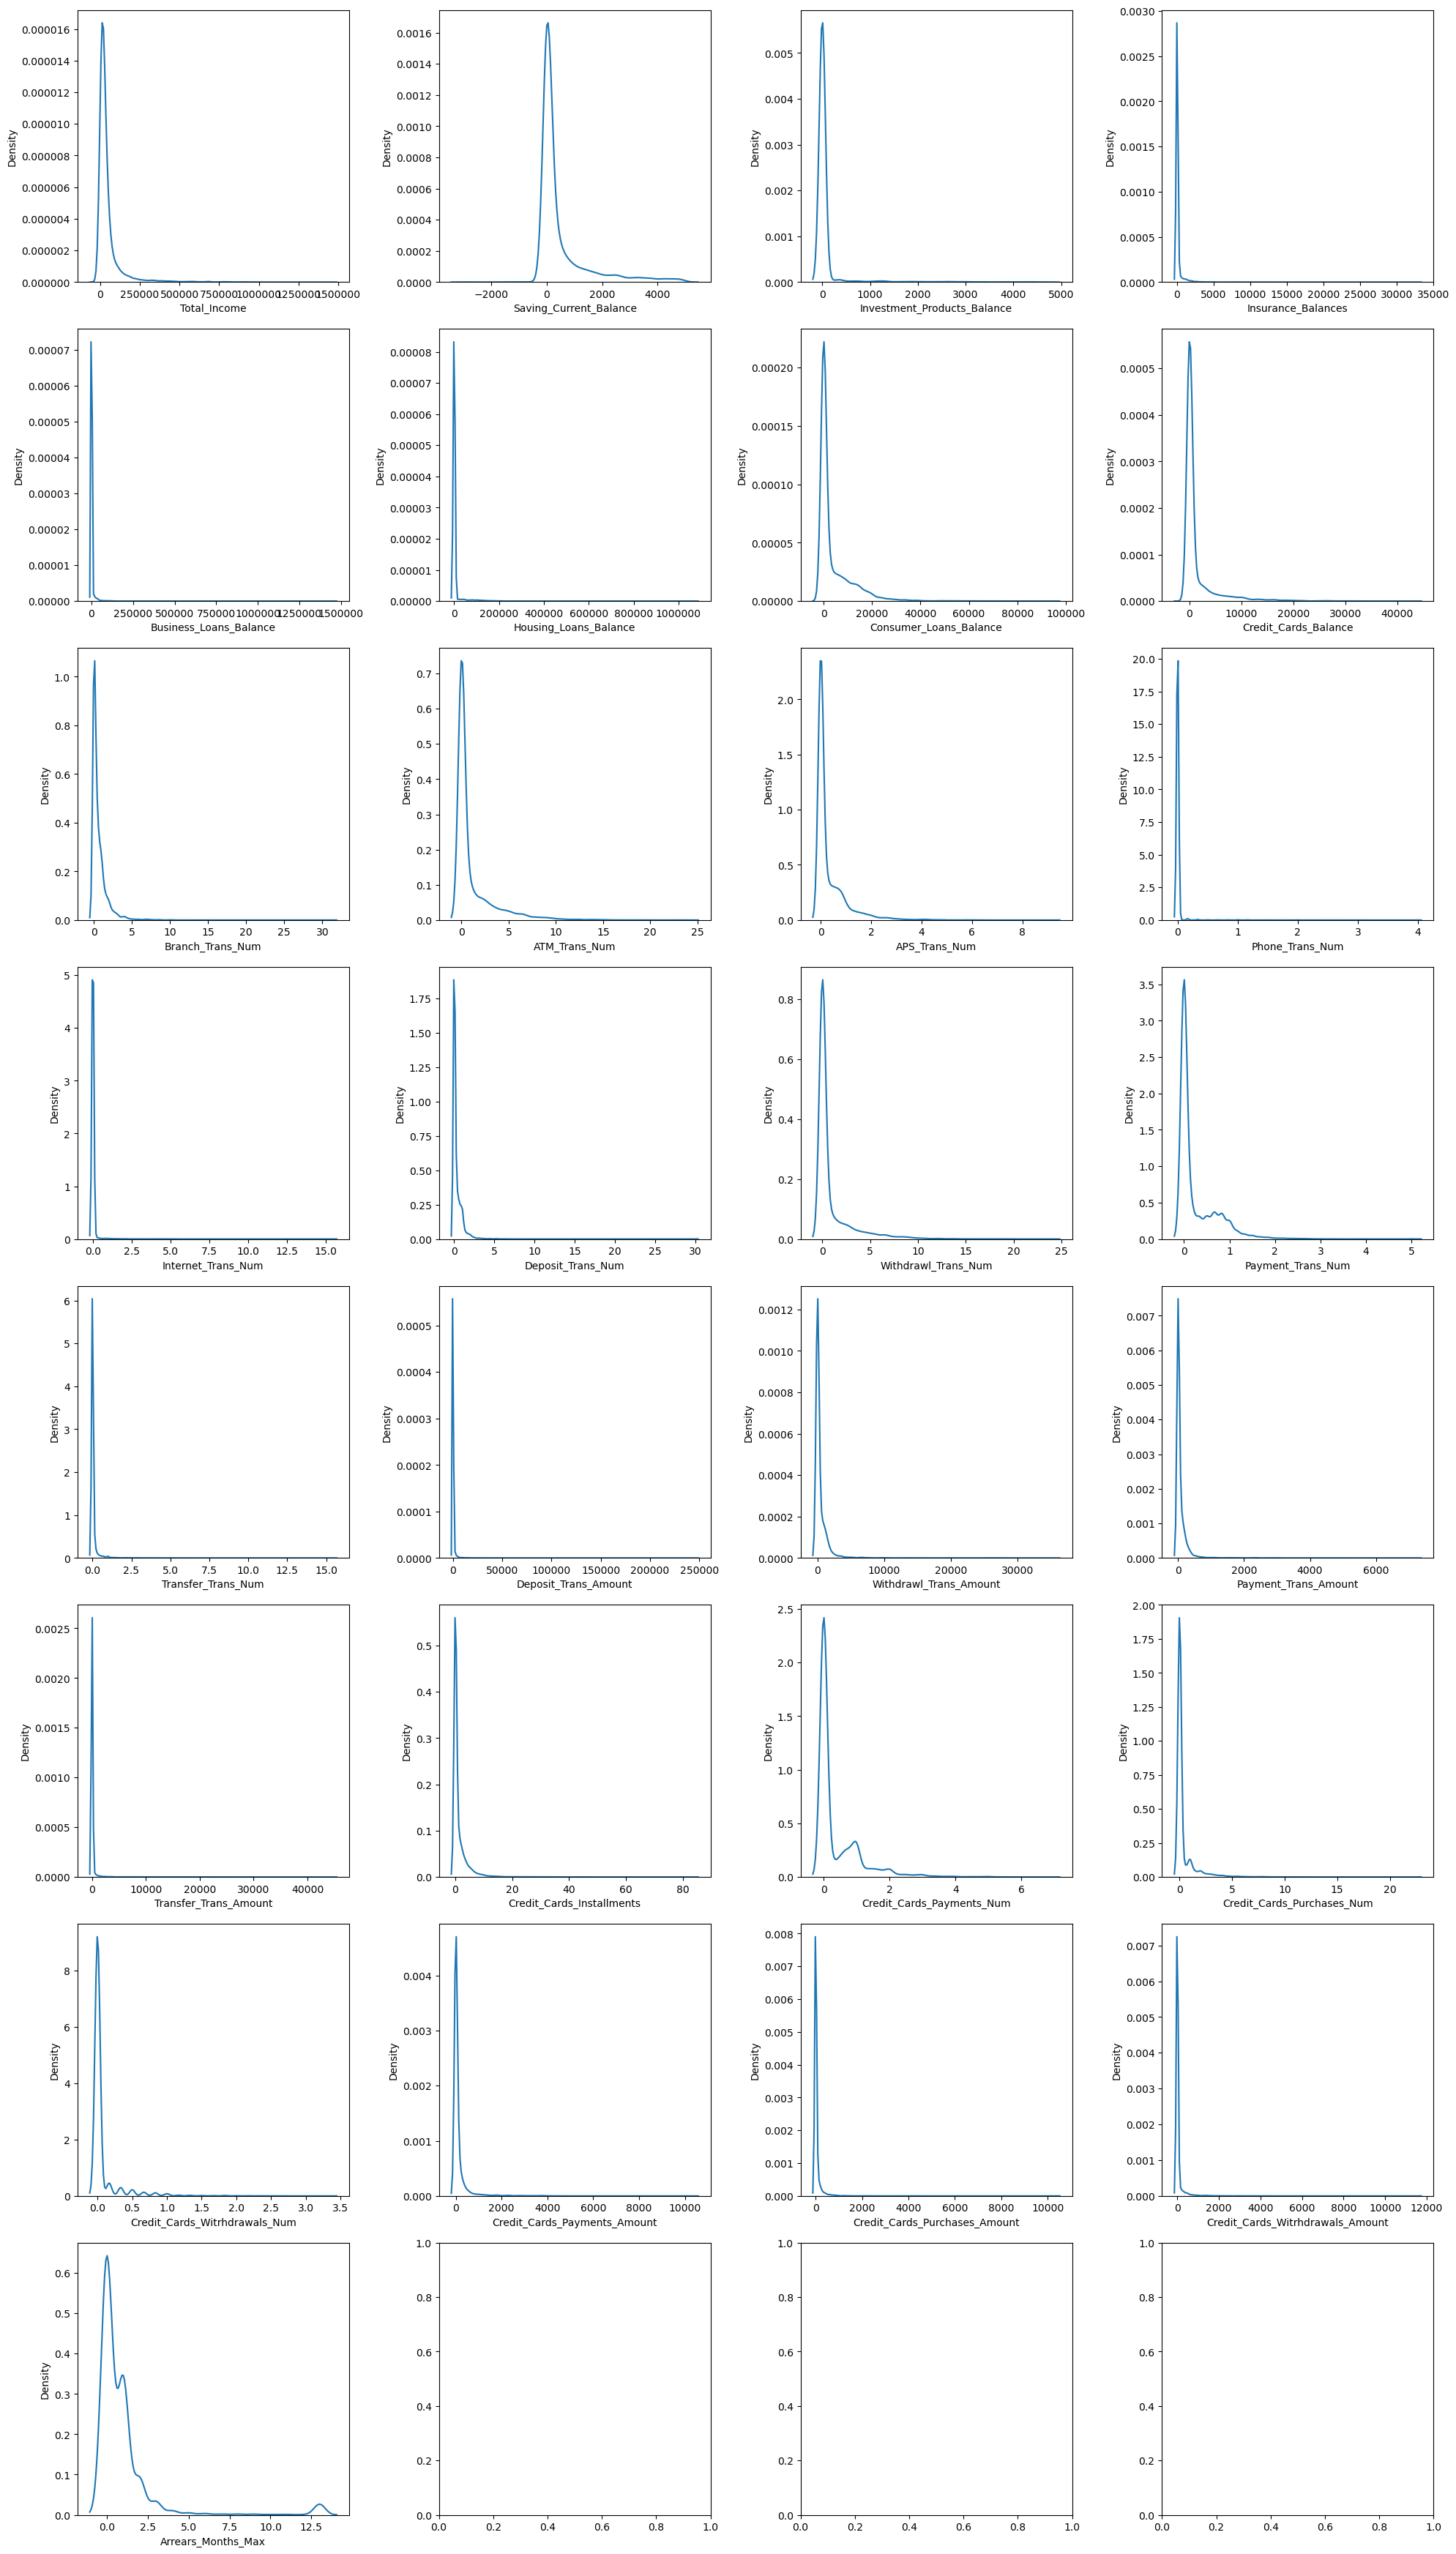

In [271]:
#creating distribution graphs for numerical features
fig, axs = plt.subplots(8,4, figsize = (20, 35))
for i, ax in zip(num_v_list, axs.ravel()):

        sns.kdeplot(data = dataset, x = i ,ax = ax)
        ax.ticklabel_format(style = "plain", axis= "x")
        ax.ticklabel_format(style = "plain", axis= "y")

plt.tight_layout()
plt.show()        

Next we can see graphs that show a distribution of numerical features. Most of the features are right-skewed which is due fact that the most values are zeros.This has a reasoning related to the nominal features where the most values are False, which implies zero in the related numerical feature – for instance, if the customer has False in the Insurance_Products_Flag (meaning that he has no insurance in the bank), therefore the Insurance_Balances will be zero. This issue will be treated later with binning.

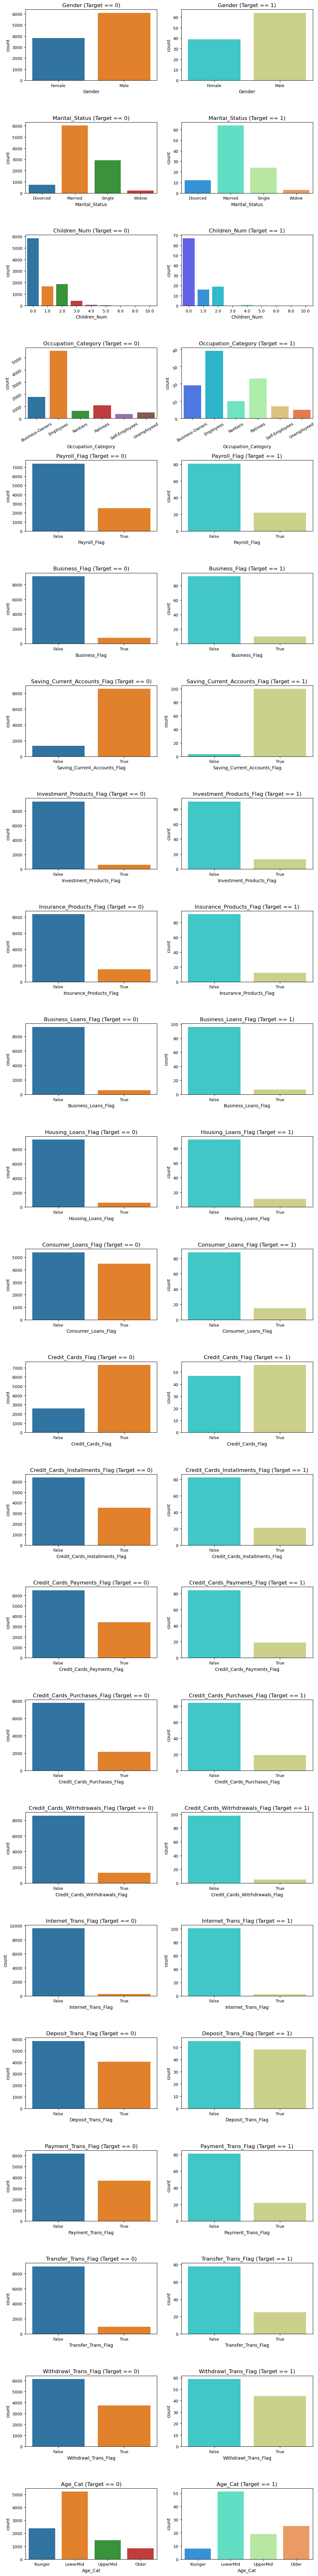

In [272]:
#Creating  graphs for categorical features.


figure,axis = plt.subplots(23,2, figsize=(10,80))

col_ind=0
axis_count = 0

for ax in axis.ravel():

    if axis_count % 2 == 0:
        sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == False], x=cat_v_list[col_ind], ax = ax)
        ax.set_title(cat_v_list[col_ind]+" (Target == 0)")

        if cat_v_list[col_ind] == "Occupation_Category":
            ax.tick_params(axis='both', which='major', labelsize=9, rotation = 30)
        else:
            ax.tick_params(axis='both', which='major', labelsize=9)
        
    else:
        sns.countplot(data=dataset[dataset["Time_Deposits_Flag"] == True], x=cat_v_list[col_ind], ax = ax, palette='rainbow')
        ax.set_title(cat_v_list[col_ind]+" (Target == 1)")

        if cat_v_list[col_ind] == "Occupation_Category":
            ax.tick_params(axis='both', which='major', labelsize=9, rotation = 30)
        else:
            ax.tick_params(axis='both', which='major', labelsize=9)

        col_ind += 1
        
    axis_count +=1

plt.tight_layout()
plt.show()

Lastly we take a look at the distribution of nominal/categorical features, divided by whether the target (Time_Deposits_Flag) equals 0 or 1.From this kind of statistics, we can notice some basic differences between the plots where target = 1 and target = 0. Such as where, Marital_Status is divorced, Occupation_Category is Retirees or Age_Cat is UpperMid and Older we see more customers having opened the term deposit account. On the other hand, in features where Children_Num is 3, Cust_loans_Flag is True or Age_Cat is Younger we see less people having opened the term deposit account. Thanks to these graphs we may get a slight idea which features may be useful for the final model and which may not.

In [273]:
#mozna smazat? ?
list(dataset[cat_v_list].describe().transpose().index)

['Gender',
 'Marital_Status',
 'Children_Num',
 'Occupation_Category',
 'Payroll_Flag',
 'Business_Flag',
 'Saving_Current_Accounts_Flag',
 'Investment_Products_Flag',
 'Insurance_Products_Flag',
 'Business_Loans_Flag',
 'Housing_Loans_Flag',
 'Consumer_Loans_Flag',
 'Credit_Cards_Flag',
 'Credit_Cards_Installments_Flag',
 'Credit_Cards_Payments_Flag',
 'Credit_Cards_Purchases_Flag',
 'Credit_Cards_Witrhdrawals_Flag',
 'Internet_Trans_Flag',
 'Deposit_Trans_Flag',
 'Payment_Trans_Flag',
 'Transfer_Trans_Flag',
 'Withdrawl_Trans_Flag',
 'Age_Cat']

<H1>Dependency analysis <H1>

In [274]:
# creating contingency table  for categorical features

cat_vars = list(dataset[cat_v_list].describe().transpose().index)+["Time_Deposits_Flag"]

for i in cat_vars:
    dataset[i] = dataset[i].astype("category")
cat_corr_mat = pd.DataFrame(columns = cat_vars, index = cat_vars)

for row in cat_corr_mat.index:
    for col in cat_corr_mat.columns:
        if (dataset[row].nunique() == 2) and ((dataset[col].nunique() == 2)):
            try:
                bin_var1 = dataset[col].astype("int")
            except:
                bin_var1 = [True if i == dataset[col].unique()[0] else False for i in dataset[col]]
            try:
               bin_var2 = dataset[row].astype("int")
            except:
                bin_var2 = [True if i == dataset[row].unique()[0] else False for i in dataset[row]]
            phi = matthews_corrcoef(bin_var1, bin_var2)
            cat_corr_mat.loc[row, col] = phi
        elif (dataset[row].nunique() > 2) or ((dataset[col].nunique() > 2)):
            data_crosstab = pd.crosstab(dataset[row], dataset[col])
            chi2, _, ___, ____ = chi2_contingency(data_crosstab, correction=False)
            cramer = np.sqrt(chi2/data_crosstab.sum().sum()/(min(data_crosstab.shape) -1))
            cat_corr_mat.loc[row, col] = cramer
cat_corr_mat

,Gender,Marital_Status,Children_Num,Occupation_Category,Payroll_Flag,Business_Flag,Saving_Current_Accounts_Flag,Investment_Products_Flag,Insurance_Products_Flag,Business_Loans_Flag,...,Credit_Cards_Payments_Flag,Credit_Cards_Purchases_Flag,Credit_Cards_Witrhdrawals_Flag,Internet_Trans_Flag,Deposit_Trans_Flag,Payment_Trans_Flag,Transfer_Trans_Flag,Withdrawl_Trans_Flag,Age_Cat,Time_Deposits_Flag
Gender,1.0,0.064373,0.052235,0.088933,-0.087323,0.068738,0.044005,-0.022863,0.016285,0.078136,...,-0.012614,-0.048326,0.032302,0.028005,0.052559,0.034361,0.013492,-0.031664,0.04421,0.001166
Marital_Status,0.064373,1.0,0.299971,0.196371,0.114699,0.071486,0.060302,0.062563,0.085872,0.071439,...,0.057558,0.044857,0.045673,0.043344,0.041945,0.066488,0.025355,0.087918,0.350832,0.020579
Children_Num,0.052235,0.299971,1.0,0.108401,0.057933,0.085864,0.021147,0.04967,0.042345,0.086147,...,0.024095,0.022199,0.026121,0.031198,0.036504,0.043598,0.021858,0.046676,0.248268,0.023089
Occupation_Category,0.088933,0.196371,0.108401,1.0,0.261287,0.441029,0.038752,0.03605,0.027344,0.367203,...,0.04648,0.060642,0.032671,0.052749,0.0962,0.088957,0.084033,0.093773,0.345172,0.047744
Payroll_Flag,-0.087323,0.114699,0.057933,0.261287,1.0,-0.142585,0.195449,-0.077686,-0.076329,-0.119432,...,-0.011377,0.031625,-0.015285,0.050607,-0.081752,-0.174675,0.066307,0.473583,0.147102,-0.009047
Business_Flag,0.068738,0.071486,0.085864,0.441029,-0.142585,1.0,0.044922,-0.031689,0.017548,0.819254,...,0.016234,0.007118,-0.001109,0.035679,0.197719,0.077114,0.130637,0.041843,0.091968,0.006882
Saving_Current_Accounts_Flag,0.044005,0.060302,0.021147,0.038752,0.195449,0.044922,1.0,-0.137847,0.003624,0.019021,...,-0.113728,-0.052955,-0.058257,0.044237,0.285265,-0.076845,0.117019,0.260883,0.069694,0.031567
Investment_Products_Flag,-0.022863,0.062563,0.04967,0.03605,-0.077686,-0.031689,-0.137847,1.0,-0.033754,-0.033247,...,-0.091781,-0.057283,-0.068446,0.016236,-0.07903,-0.113187,0.024982,-0.055134,0.074078,0.027479
Insurance_Products_Flag,0.016285,0.085872,0.042345,0.027344,-0.076329,0.017548,0.003624,-0.033754,1.0,0.019994,...,0.164325,0.103446,0.176589,0.024519,0.142576,0.264598,0.078019,-0.011969,0.082959,-0.01133
Business_Loans_Flag,0.078136,0.071439,0.086147,0.367203,-0.119432,0.819254,0.019021,-0.033247,0.019994,1.0,...,0.013839,0.003071,0.008567,0.019186,0.206965,0.092475,0.101596,0.039682,0.086867,0.004347


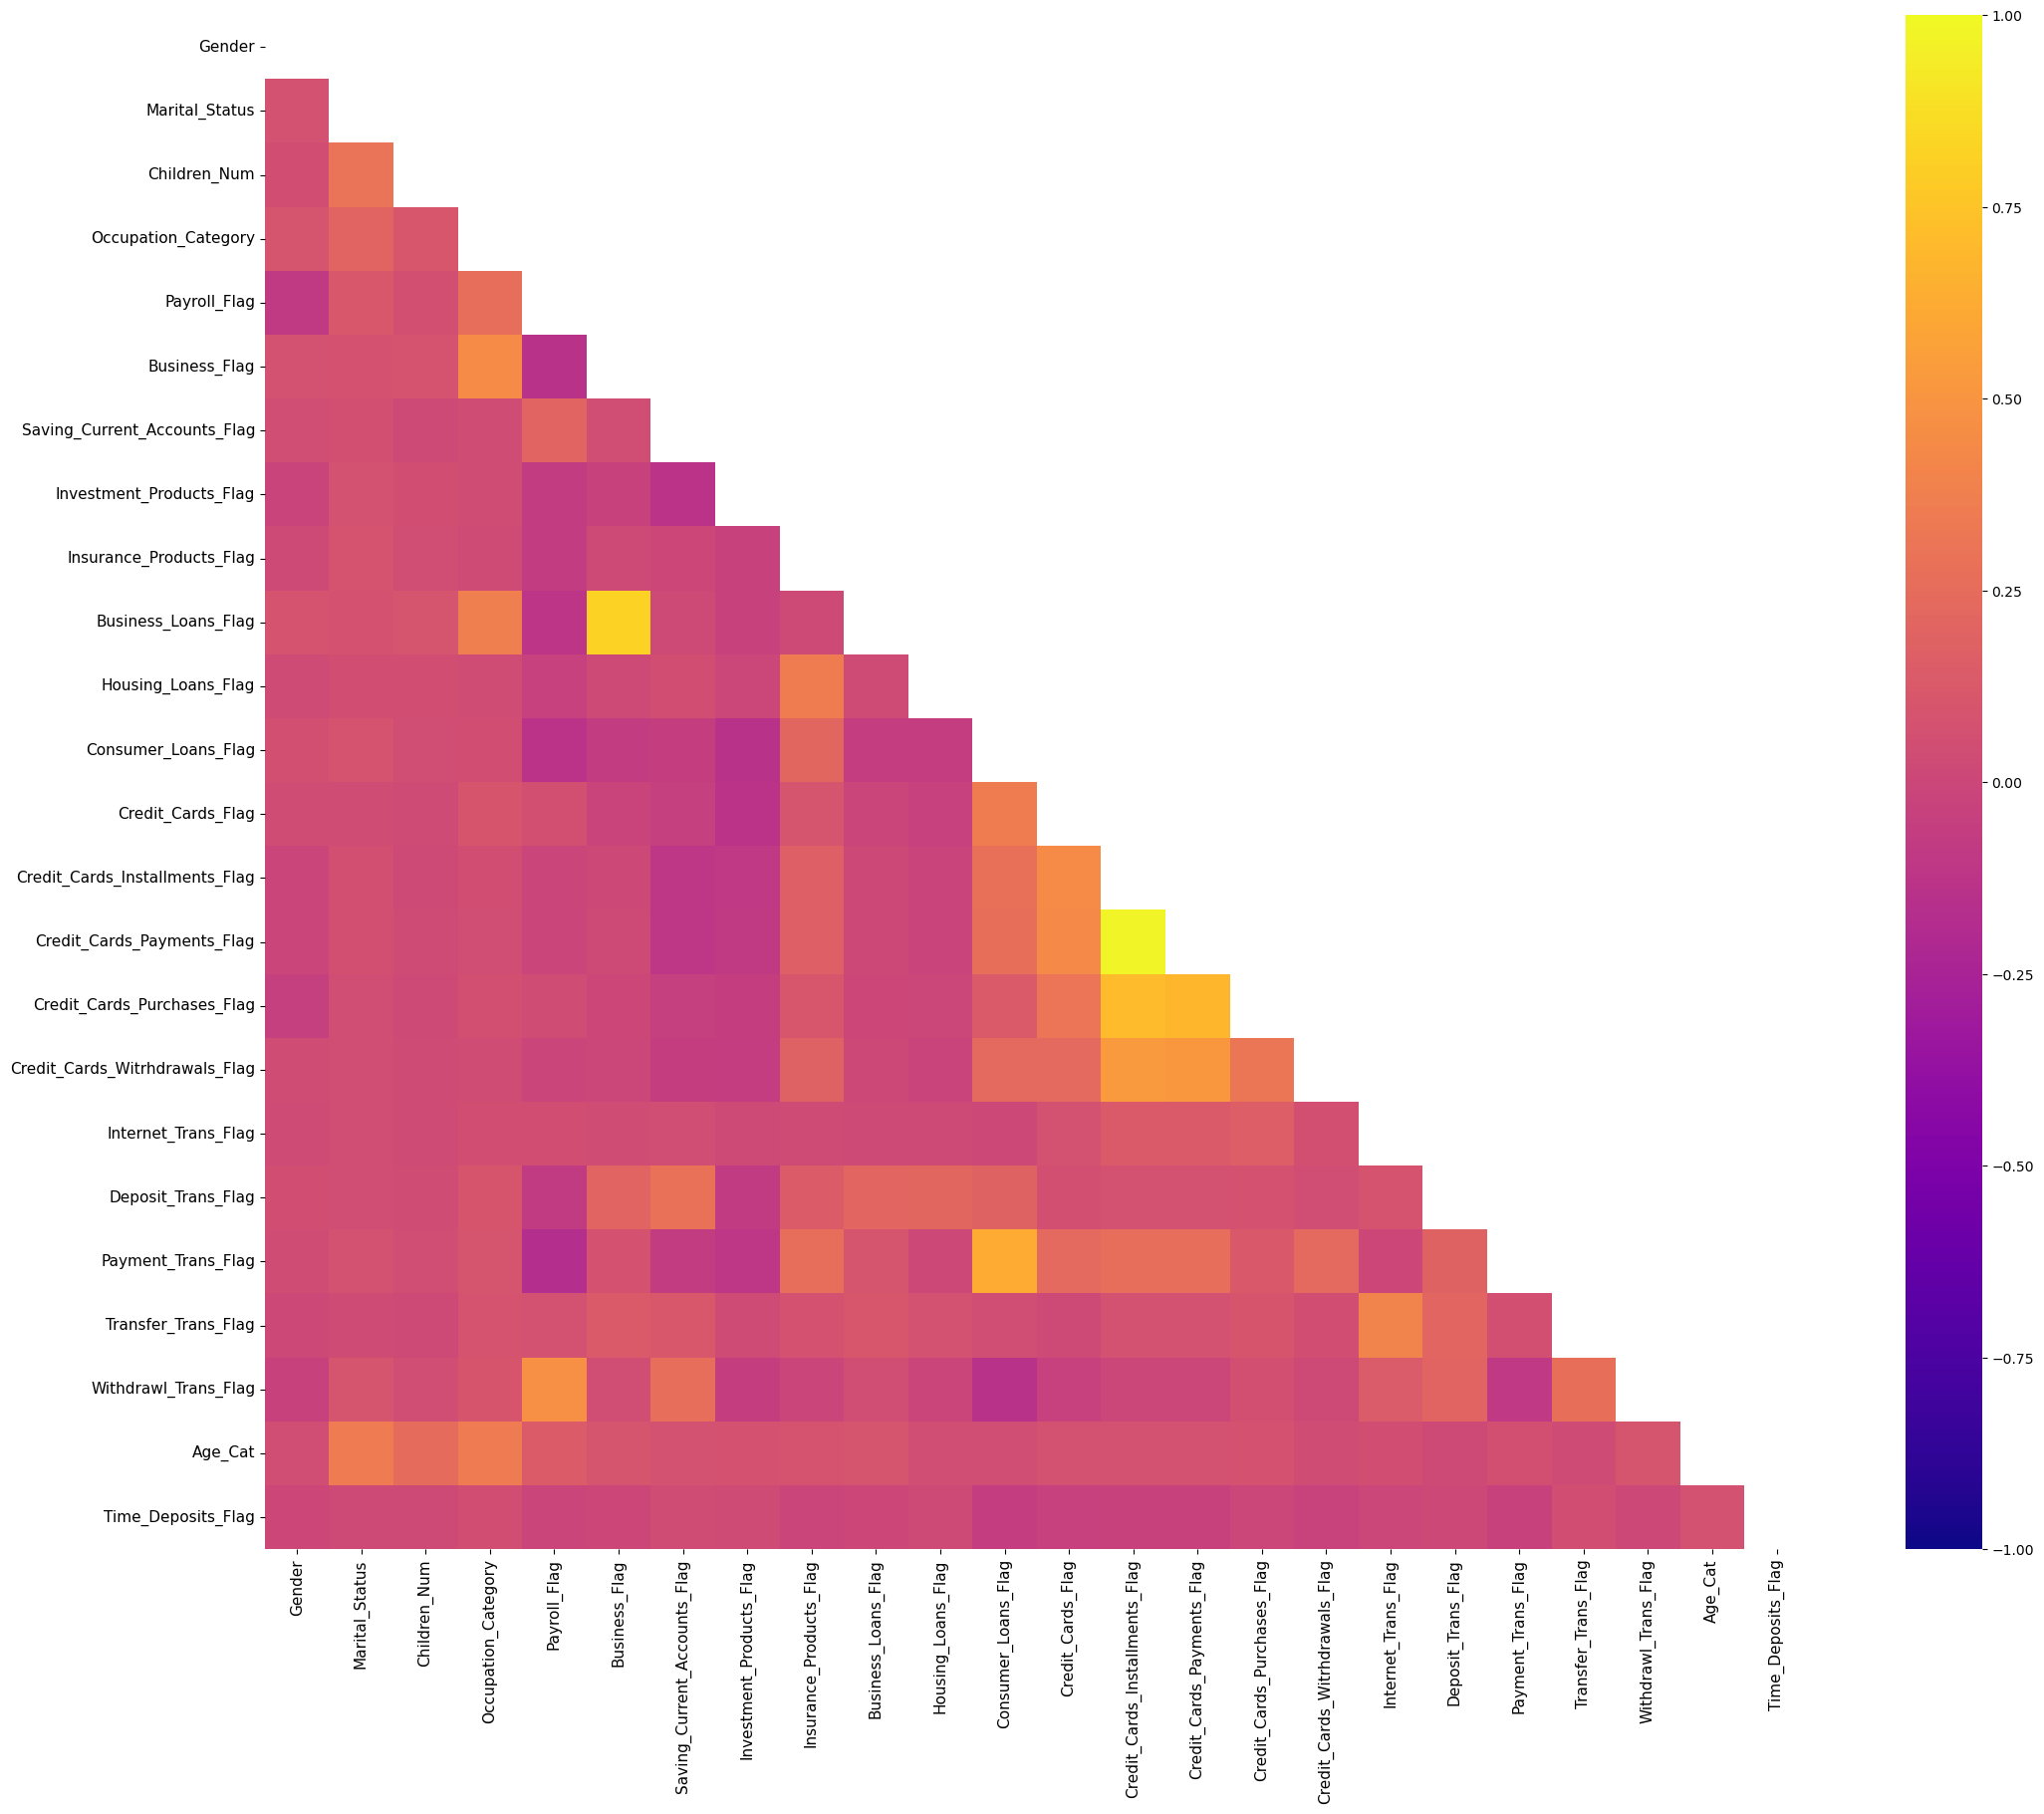

In [275]:
#creating heatmap for category features
cat_corr_mat = cat_corr_mat.astype("float")
plt.figure(figsize = (25, 20))
mask = np.triu(np.ones_like(cat_corr_mat))
cax = sns.heatmap(cat_corr_mat, vmin = -1, vmax = 1, mask = mask, cmap = "plasma")
cax.tick_params(labelsize = 11)
plt.show()


In the graph above we displayed heatmap that describes correlations between all nominal/categorical features. From here we can observe very high correlations between variables Business_Loans_Flag and Business_Flag, Credit_Card_Payments_Flag and Credit_Cards_Installment_Flag or Credit_Card_Payments_Flag and Credit_Cards_Purchase_Flag. It is obvious to have high correlations between the listed pairs, as they carry almost identical information. E.g. Credit_Card_Payments_Flag and Credit_Cards_Installment_Flag, person who has a credit card also uses it for paying regularly, person who does not obviously can not use it for paying. Later in the modeling stage we should pay attention to these pairs as it may be unnecessary to have two features with very similar information in the model.

In [276]:
#function for displaying contigency table and chi-square statistic

def chi_square(data, var1, var2 = "Time_Deposits_Flag", alpha = 0.05):


    data_crosstab = pd.crosstab(data[var1],data[var2], margins=True)

    chi2, p, dof, expected = chi2_contingency(data_crosstab, correction=False)

    print('The p-value is', p)
    #print(np.round(expected,2))
    if p <= alpha:
        print(f'Result: We reject the null hypothesis: There is a relationship between {var1} and {var2}, therefore they are dependent.')
    else:
        print(f'Result: We fail to reject the null hypothesis: There is no relationship between {var1} and {var2}, therefore they are independent.')
    return data_crosstab



Lastly we defined a function for showing whether there is a relationship between the target and chosen feature variable.
Pearson's chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table. 
Since this is statistical hypothesis testing, we first need to define the null and alternative hypotheses. 
H0: At a given confidence level (0.05), the occurrence of outcomes is statistically independent.  
H1: Alternative to H0. There is some relationship between the variables. 


In [277]:
chi_square(dataset, "Occupation_Category")

The p-value is 0.029517852109210513
Result: We reject the null hypothesis: There is a relationship between Occupation_Category and Time_Deposits_Flag, therefore they are dependent.


Time_Deposits_Flag,False,True,All
Occupation_Category,,,
Business-Owners,1756,19,1775
Employees,5570,39,5609
Rentiers,632,10,642
Retirees,1085,23,1108
Self-Employees,353,7,360
Unemployeed,501,5,506
All,9897,103,10000


In [278]:
chi_square(dataset, "Children_Num")

The p-value is 0.9982432083210295
Result: We fail to reject the null hypothesis: There is no relationship between Children_Num and Time_Deposits_Flag, therefore they are independent.


Time_Deposits_Flag,False,True,All
Children_Num,,,
0.0,5842,67,5909
1.0,1683,16,1699
2.0,1856,19,1875
3.0,415,0,415
4.0,80,1,81
5.0,14,0,14
6.0,4,0,4
8.0,2,0,2
10.0,1,0,1


In [279]:
chi_square(dataset, "Marital_Status")

The p-value is 0.8353252129791133
Result: We fail to reject the null hypothesis: There is no relationship between Marital_Status and Time_Deposits_Flag, therefore they are independent.


Time_Deposits_Flag,False,True,All
Marital_Status,,,
Divorced,727,12,739
Married,6025,64,6089
Single,2932,24,2956
Widow,213,3,216
All,9897,103,10000


In [280]:
chi_square(dataset, "Consumer_Loans_Flag")

The p-value is 6.421547162501842e-08
Result: We reject the null hypothesis: There is a relationship between Consumer_Loans_Flag and Time_Deposits_Flag, therefore they are dependent.


Time_Deposits_Flag,False,True,All
Consumer_Loans_Flag,,,
False,5403,88,5491
True,4494,15,4509
All,9897,103,10000


In [281]:
chi_square(dataset, "Credit_Cards_Flag")

The p-value is 0.0005769825542054621
Result: We reject the null hypothesis: There is a relationship between Credit_Cards_Flag and Time_Deposits_Flag, therefore they are dependent.


Time_Deposits_Flag,False,True,All
Credit_Cards_Flag,,,
False,2598,47,2645
True,7299,56,7355
All,9897,103,10000


<H1>Data Split<H1>

In [282]:
seed = 33

In [283]:
# dataset division into features and target
target = dataset["Time_Deposits_Flag"]
feature = dataset.drop("Time_Deposits_Flag", axis= 1)

variable_names = list(feature.columns[:])

X = dataset[variable_names]
y = dataset["Time_Deposits_Flag"]

In [284]:
#dataset division into training, testing and validation dataset
_, X_test, __, y_test = train_test_split(X, y, test_size=0.15, random_state = seed, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(_, __, test_size=0.1764, random_state = seed, stratify=__)

In [285]:
#control of equal division into the datasets
print("X_test", X_test.shape[0])
print("y_test", y_test.shape[0])
print("X_train", X_train.shape[0])
print("y_train", y_train.shape[0])
print("X_valid", X_valid.shape[0])
print("y_valid", y_valid.shape[0])


X_test 1500
y_test 1500
X_train 7000
y_train 7000
X_valid 1500
y_valid 1500


<H1>Oversampling<H1>

In [286]:
#zvazovali jsme i underampling ale matematicky to vychazi spatne. Abychom z rozlozeni 99/1 udelali alespon 90/10 stratili bychom 90% pozorování

In [287]:
#categorical columns indexing
cat_index = [ind for ind, i in enumerate(X_train.columns) if i in cat_v_list]
cat_index

[0,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51]

In [288]:
#aby fungoval smotenc musím převst na dataframe  a datovej typ na integer
y_train = pd.DataFrame(y_train)
y_train = y_train.astype("int")

In [289]:
y_train.value_counts()

Time_Deposits_Flag
0                     6928
1                       72
dtype: int64

In [290]:
#datatype change to objects
for i in cat_v_list:
    X_train[i] = X_train[i].astype("O")

In [291]:
#samotnej oversampling, k-near neighbours is 5 by default
#Synthetic Minority Over-sampling Technique for Nominal and Continuous
smotenc = SMOTENC(random_state=seed, categorical_features=cat_index)
X_respl, y_respl = smotenc.fit_resample(X_train, pd.DataFrame(y_train))

In [292]:
# check of oversampling 
y_respl.value_counts()

Time_Deposits_Flag
0                     6928
1                     6928
dtype: int64

In [293]:
y_respl = y_respl["Time_Deposits_Flag"]

In [294]:
#Defining the binning process
bn = BinningProcess(list(X_respl.columns), categorical_variables = cat_v_list)
bn.fit(X_respl, y_respl)

#Transform
X_train_binned = bn.transform(X_respl, metric="woe")
X_valid_binned = bn.transform(X_valid, metric="woe")
X_test_binned = bn.transform(X_test, metric="woe")

#Storing WoE
woe_bins = pd.DataFrame()
for i in X_train_binned.columns:
    var = bn.get_binned_variable(i).binning_table.build()
    var = var[(~var["Bin"].isin(["Special", "Missing"])) & (~var.index.isin(["Totals"]))]
    var["Variable"] = i
    woe_bins = pd.concat((woe_bins, var))

In [295]:
# list of all the bins
woe_bins

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable
0,[Female],4609,0.332636,2637,1972,0.427859,0.290594,0.027893,0.003474,Gender
1,[Male],9247,0.667364,4291,4956,0.535958,-0.144079,0.013830,0.001727,Gender
0,"[Widow, Divorced]",798,0.057592,666,132,0.165414,1.618488,0.124751,0.014088,Marital_Status
1,[Single],3127,0.225678,2059,1068,0.341541,0.656433,0.093898,0.011531,Marital_Status
2,[Married],9931,0.716729,4203,5728,0.576780,-0.309568,0.068142,0.008484,Marital_Status
...,...,...,...,...,...,...,...,...,...,...
1,[False],9487,0.684685,4309,5178,0.545800,-0.183713,0.023044,0.002876,Withdrawl_Trans_Flag
0,[Younger],1991,0.143692,1658,333,0.167253,1.605225,0.307004,0.034722,Age_Cat
1,[LowerMid],8033,0.579749,3690,4343,0.540645,-0.162939,0.015358,0.001918,Age_Cat
2,[UpperMid],2332,0.168303,997,1335,0.572470,-0.291936,0.014243,0.001774,Age_Cat


In [296]:
# features where number of bins = 1
list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index)

['Investment_Products_Flag',
 'Business_Loans_Flag',
 'Internet_Trans_Flag',
 'Internet_Trans_Num',
 'Phone_Trans_Num',
 'Business_Flag']

In [297]:
# dropping features where number of bins = 1 from all datasets
X_train_binned.drop(list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index), axis = 1, errors = "ignore")
X_valid_binned.drop(list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index), axis = 1, errors = "ignore")
X_test_binned.drop(list(pd.DataFrame(woe_bins["Variable"].value_counts()).query("Variable==1").index), axis = 1, errors = "ignore")

,Gender,Marital_Status,Children_Num,Occupation_Category,Total_Income,Payroll_Flag,Saving_Current_Accounts_Flag,Insurance_Products_Flag,Housing_Loans_Flag,Consumer_Loans_Flag,...,Arrears_Months_Max,Credit_Cards_Installments_Flag,Credit_Cards_Payments_Flag,Credit_Cards_Purchases_Flag,Credit_Cards_Witrhdrawals_Flag,Deposit_Trans_Flag,Payment_Trans_Flag,Transfer_Trans_Flag,Withdrawl_Trans_Flag,Age_Cat
0,-0.144079,1.618488,-0.301076,-0.840082,1.035811,1.807703,-0.144546,-0.101639,0.009540,-0.563963,...,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,0.931612,-0.413312,-0.062820,0.403177,-0.452920
1,-0.144079,-0.309568,0.093708,0.099731,0.581692,1.807703,-0.144546,-0.101639,0.009540,-0.563963,...,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,0.403177,-0.162939
2,-0.144079,-0.309568,1.596897,0.099731,1.035811,-0.241627,-0.144546,-0.101639,0.009540,-0.563963,...,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,-0.183713,-0.162939
3,-0.144079,1.618488,-0.301076,0.099731,0.251639,-0.241627,-0.144546,-0.101639,0.009540,2.353595,...,2.161359,1.898875,2.458834,1.654196,-0.141902,0.931612,-0.413312,-0.062820,-0.183713,-0.162939
4,-0.144079,-0.309568,-0.301076,0.099731,-0.283665,-0.241627,-0.144546,-0.101639,0.009540,-0.563963,...,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,0.403177,1.605225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.290594,-0.309568,-0.301076,0.099731,0.251639,1.807703,-0.144546,-0.101639,0.009540,-0.563963,...,-0.180539,1.898875,2.458834,1.654196,-0.141902,-0.355125,1.868935,-0.062820,0.403177,-0.291936
1496,-0.144079,-0.309568,1.596897,0.236926,-0.754867,-0.241627,-0.144546,0.856858,-0.144774,2.353595,...,2.161359,1.898875,2.458834,-0.199384,-0.141902,0.931612,1.868935,-0.062820,-0.183713,-0.162939
1497,0.290594,-0.309568,-0.301076,0.099731,-0.754867,-0.241627,-0.144546,0.856858,0.009540,2.353595,...,-0.087917,1.898875,2.458834,1.654196,5.438079,0.931612,1.868935,0.940608,0.403177,1.605225
1498,0.290594,-0.309568,1.596897,0.236926,-0.283665,-0.241627,-0.144546,-0.101639,0.009540,-0.563963,...,-0.180539,-0.386210,-0.392096,-0.199384,-0.141902,-0.355125,-0.413312,-0.062820,-0.183713,1.605225


<H1>Modeling + Hyperparameter tuning<H1>

In [298]:
#change of datatype back to "category" 
y_respl = y_respl.astype("category")


In [299]:
y_respl = y_respl.values.tolist()


In [300]:
#krizova validace
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=seed)

In [301]:
#definovani modelu
dt = DecisionTreeClassifier(random_state = seed)
rf = RandomForestClassifier(random_state = seed)
lr = LogisticRegression(random_state = seed)
xgb = XGBClassifier(random_state = seed)

In [302]:
#Hyperparameter space - Logistic regression
lr_space = dict()
lr_space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', "sag", "saga"]
lr_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
lr_space['C'] = loguniform(1e-5, 1000)
#lr_space["fit_intercept"] = True

In [303]:
#Hyperparameter space - Decision Tree
dt_space = dict()
dt_space["criterion"] = ["gini", "entropy", "log_loss"]
dt_space["max_depth"] = list(range(4,50,2))
dt_space["max_features"] = list(range(2,30,2)) + ["auto", "sqrt", "log2"]


In [304]:
#Hyperparameter space - Random Forest
rf_space = dict()
rf_space["criterion"] = ["gini", "entropy", "log_loss"]
rf_space["max_depth"] = list(range(4,50,2))
rf_space["max_features"] = list(range(2,30,2)) + ["auto", "sqrt", "log2"]
rf_space["n_estimators"] = list(range(100,1000,50))

In [305]:
#Hyperparameter space - Extreme Gradient boosting Classifier
xgb_space = dict()
xgb_space['n_estimators'] = list(range(100,1000,50))
xgb_space["learning_rate"] = stats.uniform(0.01, 0.2)
xgb_space["min_child_weight"] = [0.75, 1, 1.25, 2, 3.5, 5]
xgb_space["gamma"] = [0.5, 0.75, 1, 1.25, 1.5, 2.5, 3, 5]
xgb_space["subsample"] = [0.4, 0.5, 0.6, 0.8, 1.0]
xgb_space["colsample_bytree"] = [0.6, 0.8, 1.0]
xgb_space["max_depth"] = list(range(2,50,2))

In [306]:
X_train = X_train_binned
y_train = y_respl
y_valid = y_valid.astype("int")


In [307]:
#Random_Forest
r_search_rf = RandomizedSearchCV(estimator = rf, param_distributions= rf_space , random_state=seed, scoring = "roc_auc")
r_search_rf.fit(X_train, y_train)
rs_rf_param = r_search_rf.best_params_


#Decision_Tree
r_search_dt = RandomizedSearchCV(estimator = dt, param_distributions= dt_space , random_state=seed, scoring = "roc_auc")
r_search_dt.fit(X_train, y_train)
rs_dt_param = r_search_dt.best_params_

#Logistic_Regression
r_search_lr = RandomizedSearchCV(estimator = lr, param_distributions= lr_space , random_state=seed, scoring = "roc_auc")
r_search_lr.fit(X_train, y_train)
rs_lr_param = r_search_lr.best_params_

#Extreme Gradient boosting Classifier
#vyber nejlepsich parametru
r_search_xgb = RandomizedSearchCV(xgb, param_distributions=xgb_space, n_iter = 5, n_jobs = 4, cv = cv, verbose = 3, random_state = seed )
#trenovani
r_search_xgb.fit(X_train, y_train)
#nejlepsi parametry
rs_xgb_param = r_search_xgb.best_params_

print("Random_Forest:", rs_rf_param)
print("Decision_Tree:", rs_dt_param)
print("Logistic_Regression:", rs_lr_param)
print("XGBoost", rs_xgb_param)

Fitting 21 folds for each of 5 candidates, totalling 105 fits
[01:07:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random_Forest: {'n_estimators': 750, 'max_features': 4, 'max_depth': 26, 'criterion': 'entropy'}
Decision_Tree: {'max_features': 26, 'max_depth': 10, 'criterion': 'log_loss'}
Logistic_Regression: {'C': 516.676680460823, 'penalty': 'none', 'solver': 'sag'}
XGBoost {'colsample_bytree': 1.0, 'gamma': 1.25, 'learning_rate': 0.05955365688734126, 'max_depth': 36, 'min_child_weight': 3.5, 'n_estimators': 250, 'subsample': 0.8}


In [308]:
#Nejlepsi sady hyperparametru - Vytunene modely pomoci RSCV
b_rf_est = r_search_rf.best_estimator_
b_dt_est = r_search_dt.best_estimator_
b_lr_est = r_search_lr.best_estimator_
b_xgb_est = r_search_xgb.best_estimator_

In [309]:
#save 4 models 
model_rf = open("rf_hyp.pkl", "wb")
pickle.dump(b_rf_est, model_rf)
model_rf.close()

model_dt = open("dt_hyp.pkl", "wb")
pickle.dump(b_dt_est, model_dt)
model_dt.close()

model_lr = open("lr_hyp.pkl", "wb")
pickle.dump(b_lr_est, model_lr)
model_lr.close()

model_xgb = open("xgb_hyp.pkl", "wb")
pickle.dump(b_xgb_est, model_xgb)
model_xgb.close()

In [310]:
#Loading of the model (Peter) 

#model_rf = open("rf_hyp.pkl", "rb")
#loaded_model_rf = pickle.load(model_rf)

<H1>Feature Selection<H1>

In [311]:
#Features selection - pro kazdy model vybirame optimalni sadu features 

rf_feat_sel = RFECV(estimator=b_rf_est, cv=cv, scoring="roc_auc", n_jobs = -1)
rf_feat_sel.fit(X_train, y_train)
print("rf is done")
dt_feat_sel = RFECV(estimator=b_dt_est, cv=cv, scoring="roc_auc", n_jobs = -1)
dt_feat_sel.fit(X_train, y_train)
print("dt is done")
lr_feat_sel = RFECV(estimator=b_lr_est, cv=cv, scoring="roc_auc", n_jobs = -1)
lr_feat_sel.fit(X_train, y_train)
print("lr is done")
xgb_feat_sel = RFECV(estimator=b_xgb_est, cv=cv, scoring="roc_auc", n_jobs = -1)
xgb_feat_sel.fit(X_train, y_train)
print("xgb is done")

rf is done
dt is done
lr is done
[02:27:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:27:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:27:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the 

In [312]:
#save 4 FS objects

FS_rf = open("rf_FS.pkl", "wb")
pickle.dump(rf_feat_sel, FS_rf)
FS_rf.close()

FS_dt = open("dt_FS.pkl", "wb")
pickle.dump(dt_feat_sel, FS_dt)
FS_dt.close()

FS_lr = open("lr_FS.pkl", "wb")
pickle.dump(lr_feat_sel, FS_lr)
FS_lr.close()

FS_xgb = open("xgb_FS.pkl", "wb")
pickle.dump(xgb_feat_sel, FS_xgb)
FS_xgb.close()

In [313]:
#vypis fíčrů
#prepsat fit na sel
#compress
rf_selected = list(compress(X_train.columns.tolist(), rf_feat_sel.support_.tolist()))
dt_selected = list(compress(X_train.columns.tolist(), dt_feat_sel.support_.tolist()))
lr_selected = list(compress(X_train.columns.tolist(), lr_feat_sel.support_.tolist()))
xgb_selected = list(compress(X_train.columns.tolist(), xgb_feat_sel.support_.tolist()))

In [328]:
dt_selected

['Gender',
 'Marital_Status',
 'Children_Num',
 'Occupation_Category',
 'Total_Income',
 'Payroll_Flag',
 'Business_Flag',
 'Saving_Current_Accounts_Flag',
 'Insurance_Products_Flag',
 'Housing_Loans_Flag',
 'Consumer_Loans_Flag',
 'Credit_Cards_Flag',
 'Saving_Current_Balance',
 'Investment_Products_Balance',
 'Insurance_Balances',
 'Business_Loans_Balance',
 'Housing_Loans_Balance',
 'Credit_Cards_Balance',
 'Branch_Trans_Num',
 'ATM_Trans_Num',
 'APS_Trans_Num',
 'Deposit_Trans_Num',
 'Withdrawl_Trans_Num',
 'Payment_Trans_Num',
 'Transfer_Trans_Num',
 'Deposit_Trans_Amount',
 'Withdrawl_Trans_Amount',
 'Payment_Trans_Amount',
 'Credit_Cards_Installments',
 'Credit_Cards_Purchases_Num',
 'Credit_Cards_Payments_Amount',
 'Credit_Cards_Purchases_Amount',
 'Credit_Cards_Installments_Flag',
 'Credit_Cards_Payments_Flag',
 'Credit_Cards_Purchases_Flag',
 'Deposit_Trans_Flag',
 'Payment_Trans_Flag',
 'Transfer_Trans_Flag',
 'Withdrawl_Trans_Flag',
 'Age_Cat']

In [314]:
#fit modelu na filtrovanejch fičrech

#Random_Forest
r_search_rf_final = RandomizedSearchCV(estimator = rf, param_distributions= rf_space , random_state=seed, scoring = "roc_auc")
r_search_rf_final.fit(X_train[rf_selected], y_train)
b_rf_est_final = r_search_rf_final.best_estimator_

rf_valid_preds = b_rf_est_final.predict_proba(X_valid_binned[rf_selected])[:,1]
rf_valid_auc = roc_auc_score(y_valid, rf_valid_preds)

#Decision_Tree
r_search_dt_final = RandomizedSearchCV(estimator = dt, param_distributions= dt_space , random_state=seed, scoring = "roc_auc")
r_search_dt_final.fit(X_train[dt_selected], y_train)
b_dt_est_final = r_search_dt_final.best_estimator_

dt_valid_preds = b_dt_est_final.predict_proba(X_valid_binned[dt_selected])[:,1]
dt_valid_auc = roc_auc_score(y_valid, dt_valid_preds)

#Logistic_Regression
r_search_lr_final = RandomizedSearchCV(estimator = lr, param_distributions= lr_space , random_state=seed, scoring = "roc_auc")
r_search_lr_final.fit(X_train[lr_selected], y_train)
b_lr_est_final = r_search_lr_final.best_estimator_

lr_valid_preds = b_lr_est_final.predict_proba(X_valid_binned[lr_selected])[:,1]
lr_valid_auc = roc_auc_score(y_valid, lr_valid_preds)

#X_Gradient_Boosting
r_search_xgb_final = RandomizedSearchCV(estimator = xgb, param_distributions= xgb_space , random_state=seed, scoring = "roc_auc")
r_search_xgb_final.fit(X_train[xgb_selected], y_train)
b_xgb_est_final = r_search_xgb_final.best_estimator_

xgb_valid_preds = b_xgb_est_final.predict_proba(X_valid_binned[xgb_selected])[:,1]
xgb_valid_auc = roc_auc_score(y_valid, xgb_valid_preds)

[02:32:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:26] WARNING:

In [315]:
#save 4 final models 
f_model_rf = open("f_rf_hyp.pkl", "wb")
pickle.dump(b_rf_est_final, f_model_rf)
f_model_rf.close()

f_model_dt = open("f_dt_hyp.pkl", "wb")
pickle.dump(b_dt_est_final, f_model_dt)
f_model_dt.close()

f_model_lr = open("f_lr_hyp.pkl", "wb")
pickle.dump(b_lr_est_final, f_model_lr)
f_model_lr.close()

f_model_xgb = open("f_xgb_hyp.pkl", "wb")
pickle.dump(b_xgb_est_final, f_model_xgb)
f_model_xgb.close()

In [316]:
print("Random_Forest", rf_valid_auc)
print("Decision_Tree", dt_valid_auc)
print("Logistic_Regression", lr_valid_auc)
print("X_Gradient_Boosting", xgb_valid_auc)

Random_Forest 0.7716054582210243
Decision_Tree 0.6205988881401616
Logistic_Regression 0.7334905660377359
X_Gradient_Boosting 0.7522742587601078


In [317]:
#TO DO:
#NA valid setu chci udělat predikce: Confusion Matrix, AUC
#Uložit přes pickle - houby
#uložit woe dataset
#vybrat nejlepší modely a poslat do voting classifier
#final model natrenovat na spojenem datasetu valid + train
#evaluace na test


In [1]:
final_features = rf_selected

NameError: name 'rf_selected' is not defined

In [319]:
#data pro fit finalniho modelu 
y_train_valid = pd.concat((y_train, y_valid))
X_train_valid_filtered = pd.concat((X_train, X_valid_binned))[final_features]
X_test_filtered = X_test_binned[final_features]

In [ ]:
#Loading of the model (Peter) 

model_rf = open("f_rf_hyp.pkl", "rb")
loaded_model_rf = pickle.load(model_rf)

In [320]:
#final_model = best neco --podle to co mi vyjde nejlip auc (random forrest)
final_model = loaded_model_rf

In [321]:
#final_model.fit(X_train_valid_filtered, y_train_valid)

In [322]:
#Evaluace na X_test_filtered
#AUC
#Confusion matrix -> s defult cutoff a s optimalnim cutoff
#f1
#KS
#brier
# F1, Accuracy, Precision, Recall -> ty vychazi z confuzing matrixu
#Kouknou k Petrovi na houby, pro ktere metriky je treba .predict a pro ktere .predict_proba
#ROC křivku
#Learning curve
#Shaps

In [326]:
#Confusion matrix
y_preds_proba = b_rf_est_final.predict_proba(X_valid_binned)[:,1]
fpr, tpr, thresholds =roc_curve(y_valid, y_preds_proba)
diff = abs(fpr-tpr)
threshold = thresholds[np.argmax(diff)]
y_preds = pd.Series(b_rf_est_final.predict_proba(X_valid_binned)[:,1]).apply(lambda x: 1 if x > threshold else 0)
confusion_matrix(y_valid, y_preds)

array([[1017,  467],
       [   4,   12]], dtype=int64)

In [325]:
#AUC
y_preds_auc = b_rf_est_final.predict_proba(X_valid_binned)[:,1]
roc_auc_score(y_valid, y_preds_auc)

0.7716054582210243